# Reducing Bok Spectra in Python
Noah Franz

For applying the calibration images to the science images I used
http://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html

To extract the 1d spectrum and wavelength correction
1. https://learn.astropy.org/tutorials/1-SpectroscopicTraceTutorial.html
2. https://learn.astropy.org/tutorials/2-WavelengthCalibration.html
3. https://learn.astropy.org/tutorials/3-Trace_Extract_Wavelength-CalibrateSpectrum.html

### Imports

In [1]:
# imports for this tutorial

import os, glob
from copy import deepcopy
from subprocess import run

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

from rascal.calibrator import Calibrator
from rascal.atlas import Atlas
from rascal.util import refine_peaks

from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
from astropy.nddata import CCDData
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
import ccdproc

/home/nfranz/.local/lib/python3.11/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:
# useful variables for this entire notebook

obj_name = 'sn2023tpl'
standard_name = 'feige110'
datadir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'bok', '2023Dec14')

science = glob.glob(os.path.join(datadir, obj_name, '*.fits')) # science image files
flats = glob.glob(os.path.join(datadir, 'flats', '*.fits')) # flat image files
standard = glob.glob(os.path.join(datadir, standard_name, '*.fits')) # standard star image files
zeros = glob.glob(os.path.join(datadir, 'zero', '*.fits')) # Zero images
focus = glob.glob(os.path.join(datadir, 'focus', '*.fits')) # focus images, pretty sure we don't need these

In [27]:
# useful functions

def read_imgs(fitslist, method='average', debug=False, min_trim=40, max_trim=1200, **kwargs):
    '''
    fitslist [list[str]]: List of fits files to read in
    method [str]: the method to stack the images by
    debug [bool]: if true plot some debug plots
    **kwargs: Any other arguments to pass to ccdproc.combine
    '''
    
    spectra2d = ccdproc.combine(fitslist, method=method, unit=u.count, sigma_clip=True, 
                                sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                sigma_clip_func=np.ma.median, mem_limit=350e6
                                )
    spectra2d = ccdproc.trim_image(spectra2d[min_trim:, :max_trim])
    
    if debug:
        fig, ax = plt.subplots(figsize=(18,6))
        ax.imshow(spectra2d)
        
    return spectra2d

def compute_light_frac(img, center, width):
    '''
    Computes the fraction of light within the width around the center
    '''
    top = (center+width).astype(int)
    bot = (center-width).astype(int)
    
    arr = np.array([img[int(val)-width:int(val)+width,ii] for ii, val in enumerate(center)])

    region = np.sum(arr)
    tot = np.sum(img)
    
    return region/tot
    
def extract_trace_profile(spec, polyfit, center, debug=False):
    '''
    Dynamically extract a trace profile from the reduced 2d spectrum
    
    This function varies the width of the trace profile to get the extracted light fraction
    to be >= the specified maximum light fraction
    
    Args:
        spec [np.ndarray]: 2D spectrum, reduced
        polyfit [function]: A callable function with the model for the 2D spectrum center
        debug [bool]: will generate debug plots if True
    '''

    max_frac = 0.1 # THIS MIGHT NEED TO GET TUNED BY HAND!!!

    width_init = 1
    light_frac_init = compute_light_frac(spec, center, width_init)

    dwidth = 1
    up = True
    light_frac = light_frac_init
    width = width_init

    while light_frac < max_frac:

        new_light_frac = compute_light_frac(spec, center, width)
        if new_light_frac > light_frac:
            light_frac = new_light_frac

        width += dwidth
    
    return width
        
def trace_spectrum(spec, isarc=False, background_subtract=True, debug=False):
    '''
    Extract a trace of the 2d spectrum
    '''
    
    # first estimate the trace values using argmax
    # this should give an estimate of factor and center
    if isarc:
        # for an arc we can just take a slice down the center
        center_idx = spec.shape[0]//2
        yvals = np.ones(spec.shape[1])*center_idx  # draw the line down the center
    else:
        yvals = np.argmax(spec, axis=0)

    print(yvals)

    xvals = np.arange(spec.shape[1])
    polymodel = Polynomial1D(degree=3)
    linfitter = LinearLSQFitter()
    est_fit = linfitter(polymodel, xvals, yvals)
    est_center = est_fit(xvals)
    est_width = extract_trace_profile(spec, est_fit, est_center)
    
    # then background subtract
    # estimate the most common value
    factor = est_width
    
    yhist = np.histogram(yvals, len(yvals)//factor)
    ycomm_idx = yhist[0].argmax()
    ycomm = int(yhist[1][ycomm_idx])
    print(ycomm_idx, ycomm)

    yaxis = np.repeat(np.arange(ycomm-factor, ycomm+factor)[:,None],
                      spec.shape[1], axis=1)

    # one way to define background
    #background=np.median(spectra2d)

    # arguably a better way to define background
    # since this finds the average value of the background signal
    if background_subtract:
        background = deepcopy(spec)
        background[ycomm-factor:ycomm+factor, :] = 0 # set all of these to no background signal
        background=np.mean(spec, axis=0)
    else:
        background = np.zeros(spec.shape[1])
        
    if debug:
        plt.figure(figsize=(6,18))
        bckgd_toplot = spec.shape[0]*background/max(background)
        plt.plot(xvals, bckgd_toplot, 'w:', alpha=0.5)
        plt.imshow(spec, extent=[0,spec.shape[1],0,spec.shape[0]], 
                   origin='lower')
        plt.gca().set_aspect(20)
        #plt.ylim(0, spec.shape[0])
        plt.title('Background Signal 1D')
    
    # take the first moment
    weights = spec[ycomm-factor:ycomm+factor, :]-background
    where0 = np.where(np.sum(weights, axis=0) == 0)[0]
    if len(where0) > 0:
        weights[:, where0] = np.ones(weights[:, where0].shape)
    plt.imshow(weights)
    plt.gca().set_aspect(20)
    yvals = np.average(yaxis, axis=0,
                      weights=weights)
    
    if debug:
        plt.figure()
        plt.imshow(spec[ycomm-factor:ycomm+factor, :]-background)
        plt.title('Background Subtracted 2D Spectrum')
        plt.gca().set_aspect(20)
        
    # remove outliers
    # this is highly non-gaussian so take the median and remove values
    nsigma = 5
    med = np.mean(yvals)
    q = np.std(yvals)
    whereNotOutlier = np.where((yvals < (med+nsigma*q)) * (yvals > (med-nsigma*q)))[0] 
    
    xmax = xvals[whereNotOutlier]
    ymax = yvals[whereNotOutlier]
    
    # fit with a polynomial
    polymodel = Polynomial1D(degree=3)
    linfitter = LinearLSQFitter()
    fitted_polymodel = linfitter(polymodel, xmax, ymax)
    
    if debug:
        plt.figure(figsize=(6,18))
        minval = 38
        maxval = 58
        plt.imshow(spec[minval:maxval, :], extent=[0,spec.shape[1],minval,maxval], 
                   norm=LogNorm(), cmap='Greys', origin='lower')
        plt.plot(xmax, ymax, 'x')
        plt.gca().set_aspect(20)
        plt.xlabel("X Coordinate")
        plt.ylabel("Moment-1 estimated Y-value trace");
        plt.plot(xmax, fitted_polymodel(xmax), color='r');
        plt.title('Best Trace Fit')
    
    return xvals, yvals, fitted_polymodel, background
    

def extract_1d(spec, isarc=False, background_subtract=True, debug=False):
    '''
    Extract the 1d spectrum from the 2d spectrum
    '''    
    # first we fit the 2D spectrum using the moments method
    xvals, yvals, poly, bckgd = trace_spectrum(spec, isarc=isarc, 
                                               background_subtract=background_subtract,
                                               debug=debug)
    center = poly(xvals)
    
    # then we extract the trace profile
    width = extract_trace_profile(spec, poly, center, debug=debug)
    
    # then extract the 1d spectrum
    cutout = np.array([spec[int(val)-width:int(val)+width, ii] for ii, val in enumerate(center)]).T
    spectrum1d = (cutout-bckgd).mean(axis=0)
    if debug:
        plt.figure()
        plt.plot(spectrum1d)
        plt.title('Final 1D Spectrum')
        
    return spectrum1d

def wavelength_solver(arc1d, element_list=['He', 'Ne', 'Ar'], min_wave=4700, max_wave=7000, 
                     tol=100, nbins=200, max_tries=500, line_brightness=0.01, dist=10, 
                      debug=False, **kwargs):
    '''
    Solve for the wavelengths

    Args:
        arc1d [np.ndarray]: A 1D array of the arc. 
        element_list [list[str]]: A list of strings representing the elements used in 
                                  the calibration lamp. Default is ['He', 'Ne', 'Ar']
        min_wave [int]: The minimum wavelength of the filter used in Angstroms. 
                        Default is 4700AA for V-Band.
        max_wave [int]: The maximum wavelength of the filter used in Angstroms.
                        Default is 7000AA for V-Band.
        tol [int]: The range tolerance on the hough transform.
        nbins [int]: The number of x and y bins for the hough transform.
        max_tries [int]: The max tries for the fitting. Default is 5000.
        brightness [int]: The relative brightness of the lines. The prominence passed to
                          scipy.signal.find_peaks will be the inverse of this. 
                          Default is 0.01. If your lines are very dim try 0.1.
        dist [int]: The distance between lines to be passed to scipy.signal.find_peaks.
                    Default is 10.
        debug [bool]: If true plot some debug plots.
        **kwargs: Passed to the scipy.signal.find_peaks.        

    Returns:
        The wavelength array for the spectrum. This is the same length as the x length
        of the input arc.        
    '''
   
    # Now following from https://rascal.readthedocs.io/en/latest/tutorial/keck-deimos.html
    peaks, _ = find_peaks(arc1d, prominence=1/line_brightness, distance=dist) #**kwargs)
    peaks_refined = refine_peaks(arc1d, peaks, window_width=3)

    # construct the calibrator and set hyperparams of the transform
    # and the fit
    c = Calibrator(peaks_refined, arc1d)
    
    c.set_calibrator_properties(num_pix=len(arc1d),
                                plotting_library='matplotlib',
                                log_level='info')
    
    c.set_hough_properties(num_slopes=10000,
                           xbins=nbins,
                           ybins=nbins,
                           min_wavelength=min_wave,
                           max_wavelength=max_wave,
                           range_tolerance=tol,
                           linearity_tolerance=50)
    
    c.set_ransac_properties(sample_size=5,
                            top_n_candidate=5,
                            linear=True,
                            filter_close=True,
                            ransac_tolerance=5,
                            candidate_weighted=True,
                            hough_weight=1.0)

    # add the elements to the atlas
    c.add_atlas(element_list) #Atlas(elements=element_list)

    if debug:
        print('Performing the hough transform...')
    c.do_hough_transform()

    if debug:
        c.plot_arc();
        print('Performing the fit...')

    # now perform the fit
    # Order of fit_out:
    # fit_coeff, matched_peaks, matched_atlas, rms, residual, peak_util, atlas_util
    fit_out = c.fit(max_tries=500)

    # extract the wavelength array
    fit_coeff = fit_out[0]
    wave = c.polyval(c.pixel_list, fit_coeff)

    # generate some debug plots
    if debug:
        rms = fit_out[3]
        residual = fit_out[4]
        peak_util = fit_out[5]

        print("RMS: {}".format(rms))
        print("Stdev error: {} A".format(np.abs(residual).std()))
        print("Peaks utilisation rate: {}%".format(peak_util*100))
        
        c.plot_fit(fit_coeff,
                   plot_atlas=True,
                   log_spectrum=False,
                   tolerance=5);

        c.plot_search_space();

        plt.figure(figsize=(18,6))
        plt.plot(wave, spec1d)

    return wave

def get_standard(standard_dir, standard_name):
    '''
    Find the standard star file corresponding to standaed_name
    '''
   
    filename_table = ascii.read(os.path.join(standard_dir, 'calspec_names.csv'))
    
    filenames = filename_table['current_calspec']
    targnames = np.array([name.split('_')[0] for name in filenames])
    
    forglob = os.path.join(standard_dir, '*.fits')
    curr_standards = [os.path.basename(f) for f in glob.glob(forglob)]
    
    # find the filename of the standard
    whereFile = np.where(standard_name.lower() == targnames)[0]
    if len(whereFile) == 0:
        raise ValueError('We do not have access to this standard star! Please contact the developers!')
    
    filename = filenames[whereFile[0]]
    
    if filename not in curr_standards:
        # then we need to download it!
        cmd = f'wget -P {standard_dir} https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/{filename}'
        run(cmd, shell=True)

    return filename

def calibrate_flux(stand_obs, standard_name, min_wave, max_wave, debug=False):
    '''
    Calibrate the flux using the standard star
    '''

    standard_dir = os.path.join(os.path.dirname(os.getcwd()), 'py', 'sonatapy', 'standards')
    
    filename = get_standard(standard_dir, standard_name)
    
    stand = fits.open(os.path.join(standard_dir, filename))

    stand_flux = stand['SCI'].data['FLUX']
    stand_wave = stand['SCI'].data['WAVELENGTH']
    
    whereFilt = np.where((stand_wave > min_wave) * (stand_wave < max_wave))[0]

    if debug:
        plt.plot(stand_wave[whereFilt], stand_flux[whereFilt])
    
    # interpolate stand_flux is the same length as stand1d
    bestfit = interp1d(stand_wave, stand_flux)
    stand_interp = bestfit(wave)

    if debug:
        plt.plot(wave, stand_interp)

    # let's introduce units to make sure this is okay
    stand_obs = stand_obs*u.count
    stand = stand_interp*u.erg/u.cm**2/u.s
    flux_obs = spec1d.data*u.count
    
    flux = flux_obs * stand / stand_obs

    if debug:
        plt.figure()
        plt.plot(wave, flux)

    return flux

### Read in all of the relevant data and stack it



['/home/nfranz/bok/2023Dec14/sn2023tpl/sn2023tpl.0062.fits', '/home/nfranz/bok/2023Dec14/sn2023tpl/sn2023tpl.0063.fits', '/home/nfranz/bok/2023Dec14/sn2023tpl/sn2023tpl.0060.fits', '/home/nfranz/bok/2023Dec14/sn2023tpl/sn2023tpl.0064.fits', '/home/nfranz/bok/2023Dec14/sn2023tpl/sn2023tpl_arc.0065.fits', '/home/nfranz/bok/2023Dec14/sn2023tpl/sn2023tpl.0061.fits']


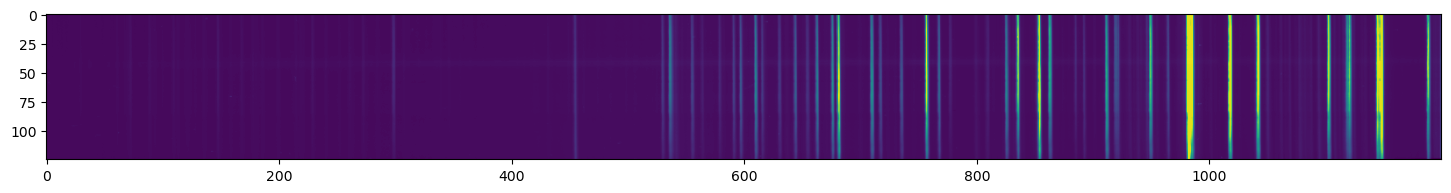

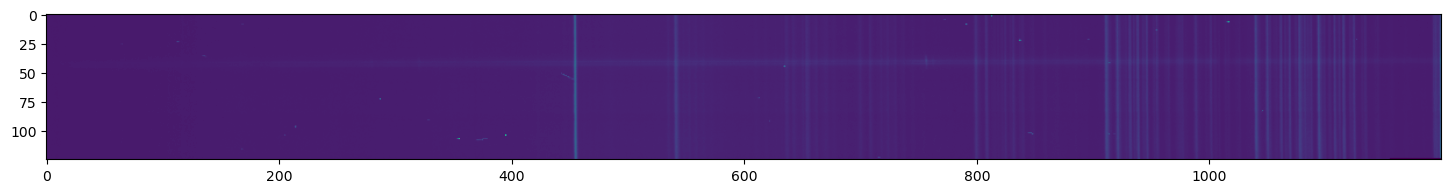

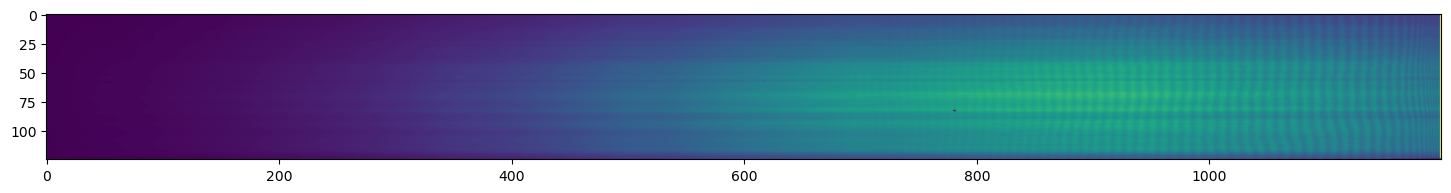

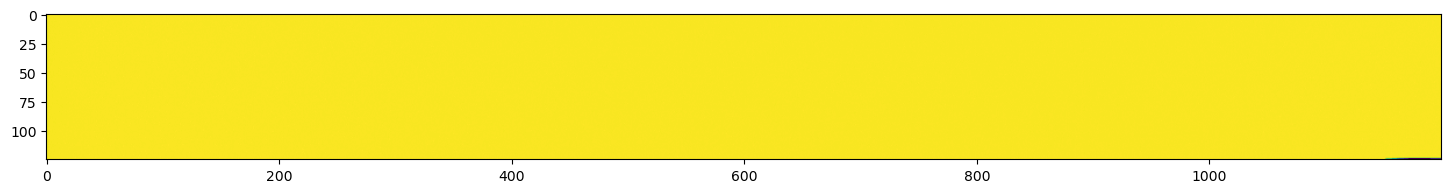

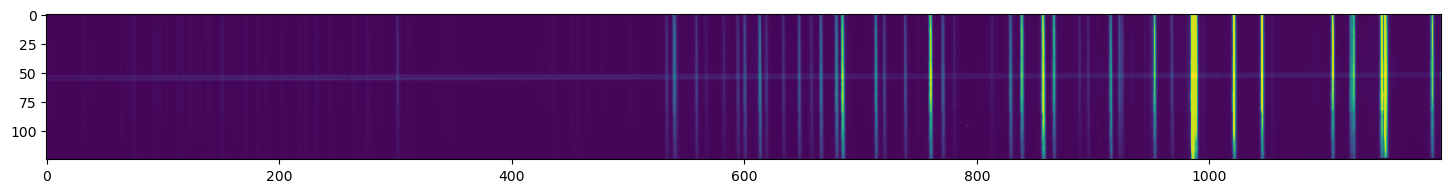

In [28]:
debug = True
print(science)
spectra2d = read_imgs(science[1:], debug=debug)
arc2d = read_imgs([science[0]], debug=debug)
flat2d = read_imgs(flats, debug=debug)
zero2d = read_imgs(zeros, debug=debug)
stan2d = read_imgs(standard, debug=debug)

### Subtract the bias from the flats

(If we had darks we would also account for those here)

The way of doing this all written out
```
# correct the flats for the bias
flat_corr = ccdproc.subtract_bias(flat2d, zero2d)

# first for the science images
science_bias_corr = ccdproc.subtract_bias(spectra2d, zero2d)
science_red = ccdproc.flat_correct(science_bias_corr, flat_corr)

# then for the arcs
arc_bias_corr = ccdproc.subtract_bias(arc2d, zero2d)
arc_red = ccdproc.subtract_bias(arc_bias_corr, flat_corr)

# plot
from matplotlib.colors import LogNorm
plt.figure(figsize=(18,6))
plt.imshow(science_red, norm=LogNorm())
```

### The shorthand `ccdproc.ccd_process`

This is much faster so this is probably the way to do it!!

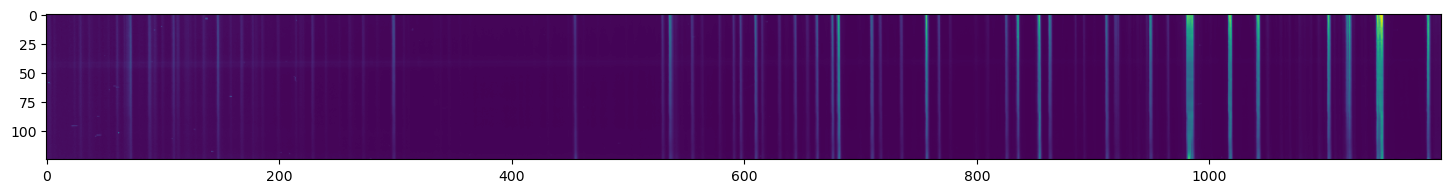

In [29]:
# the science image
science_red = ccdproc.ccd_process(spectra2d, 
                               master_bias=zero2d,
                               master_flat=flat2d)

# the arc
arc_red = ccdproc.ccd_process(arc2d, 
                               master_bias=zero2d,
                               master_flat=flat2d)

# the standard star
stan_red = ccdproc.ccd_process(stan2d, 
                               master_bias=zero2d,
                               master_flat=flat2d)

# plot
from matplotlib.colors import LogNorm
plt.figure(figsize=(18,6))
plt.imshow(science_red)#, norm=LogNorm())

### Extract the spectrum

[43 43 59 ...  1  1 41]
56 40
[54 54 54 ... 53 53 53]
180 55
[62. 62. 62. ... 62. 62. 62.]
66 61


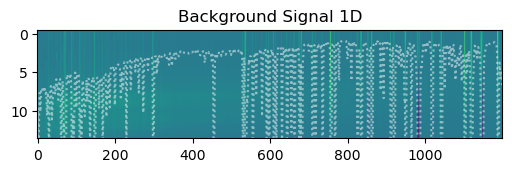

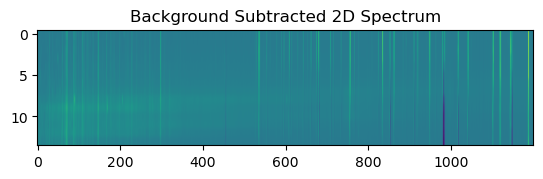

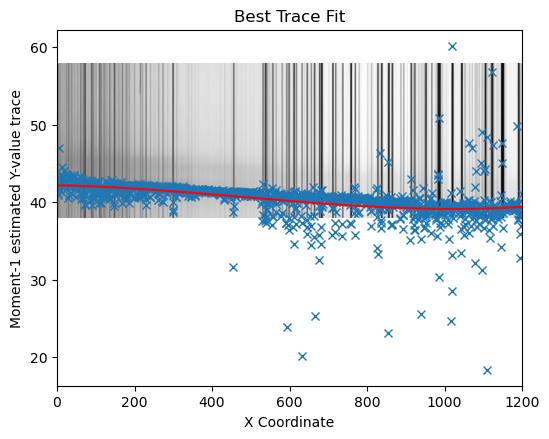

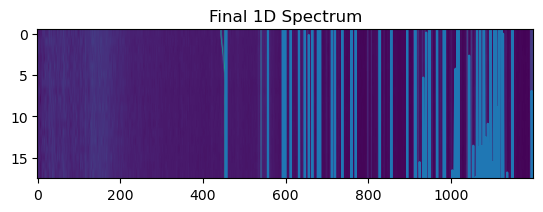

In [30]:
spec1d = extract_1d(science_red.data, debug=True)
stand1d = extract_1d(stan_red.data)
arc1d = extract_1d(arc_red.data, isarc=True, background_subtract=False, debug=False)

### Solve for the wavelength

[Thu, 21 Dec 2023 13:06:05] INFO [calibrator.py:930] num_pix is set to 1200.
[Thu, 21 Dec 2023 13:06:05] INFO [calibrator.py:942] pixel_list is set to None.
[Thu, 21 Dec 2023 13:06:05] INFO [calibrator.py:971] Plotting with matplotlib.
[Thu, 21 Dec 2023 13:06:05] WARNING [calibrator.py:1299] Using add_atlas is now deprecated. Please use the new Atlas class.


Performing the hough transform...


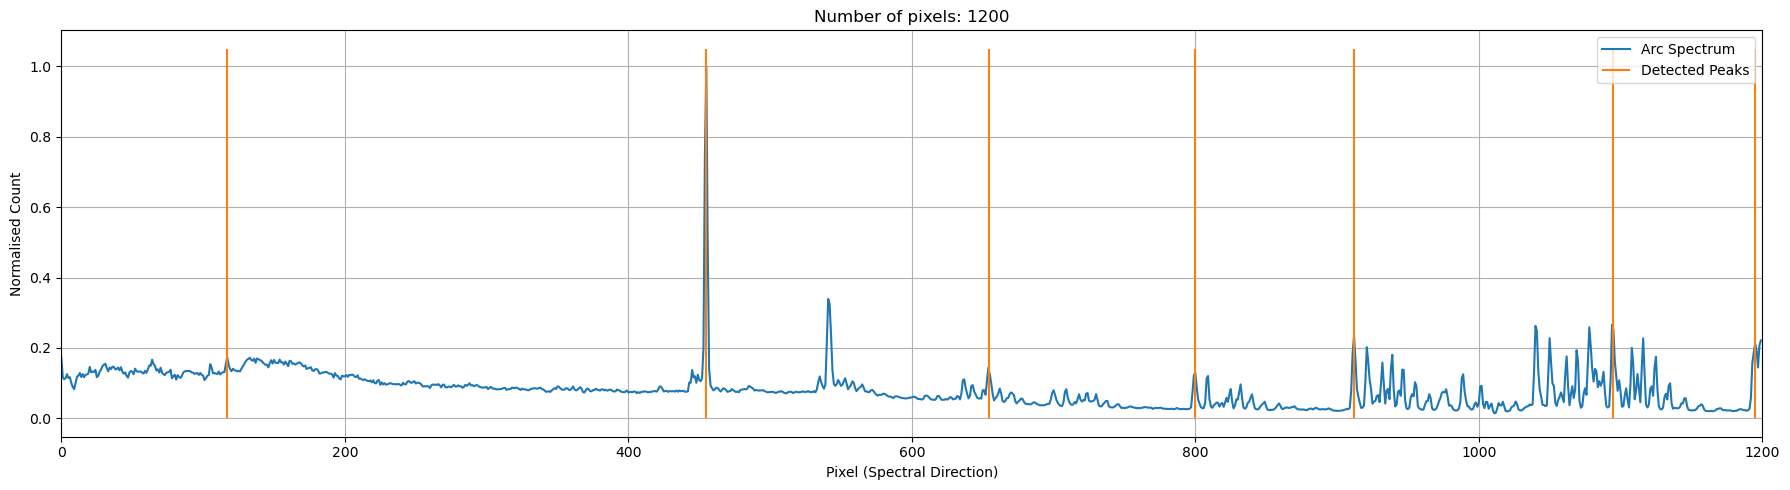

Performing the fit...


  0%|          | 0/500 [00:00<?, ?it/s]

[Thu, 21 Dec 2023 13:06:08] INFO [calibrator.py:750] Found: 6
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:805] Peak at: 4892.152573756838 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:809] - matched to 4892.152573756838 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:805] Peak at: 5511.400556822647 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:809] - matched to 5511.400556822647 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:805] Peak at: 5902.372206754704 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:809] - matched to 5902.372206754704 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:805] Peak at: 6183.063205962765 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:809] - matched to 6183.063205962765 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:805] Peak at: 6384.619712851145 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:809] - matched to 6384.619712851145 A
[Thu, 21 Dec 2023 13:06:09] INFO [plotting.py:805] Peak at: 6678.174958705588 A
[Thu, 21 Dec 2023 13:06:09] INFO [plot

RMS: 0.6090935274691169
Stdev error: 0.39731650835191434 A
Peaks utilisation rate: 85.71428571428571%


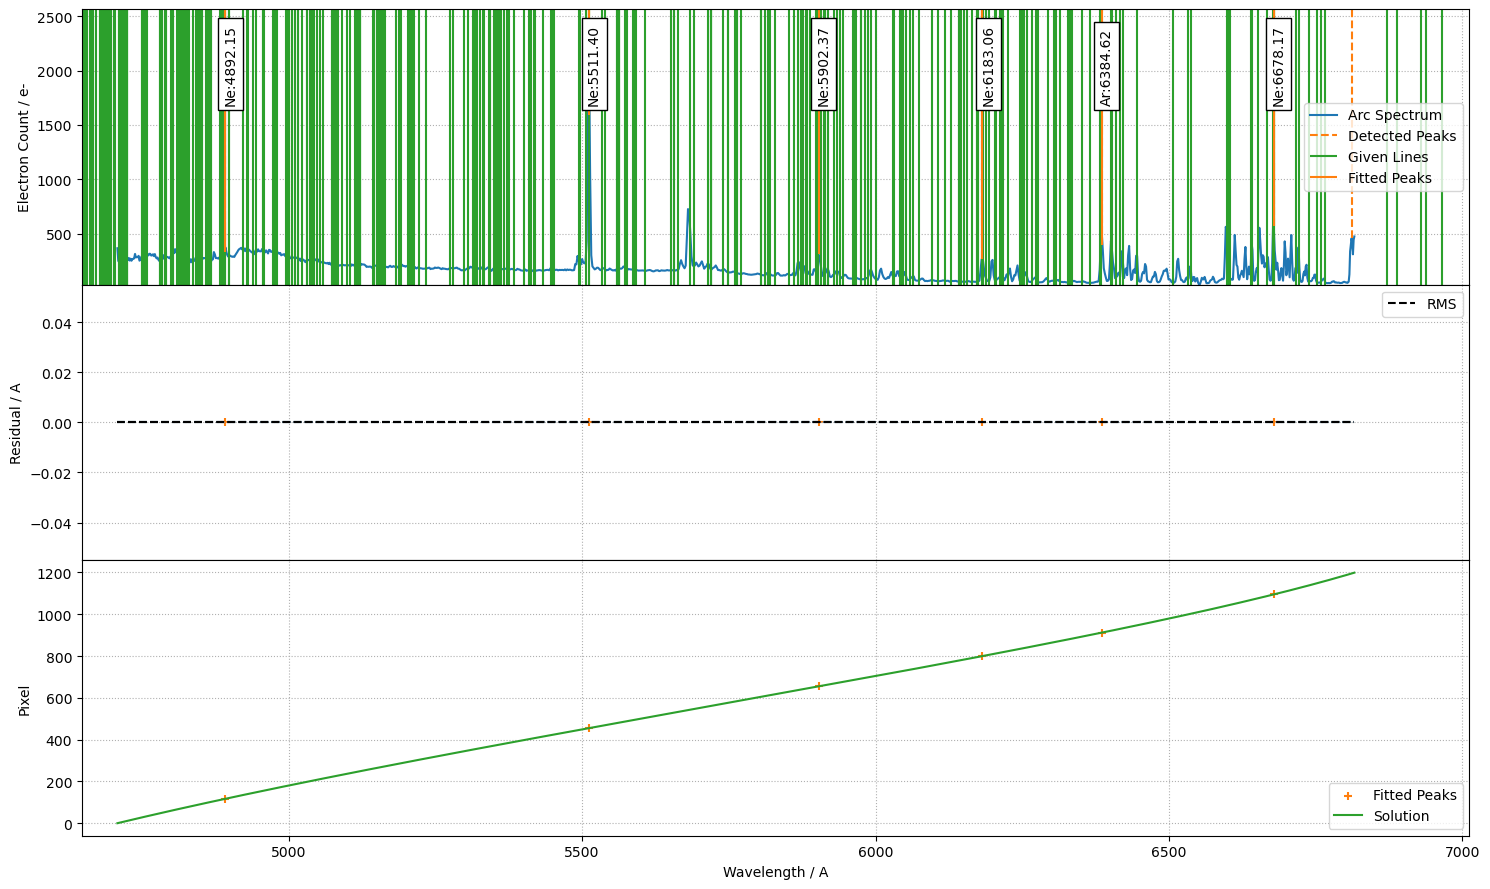

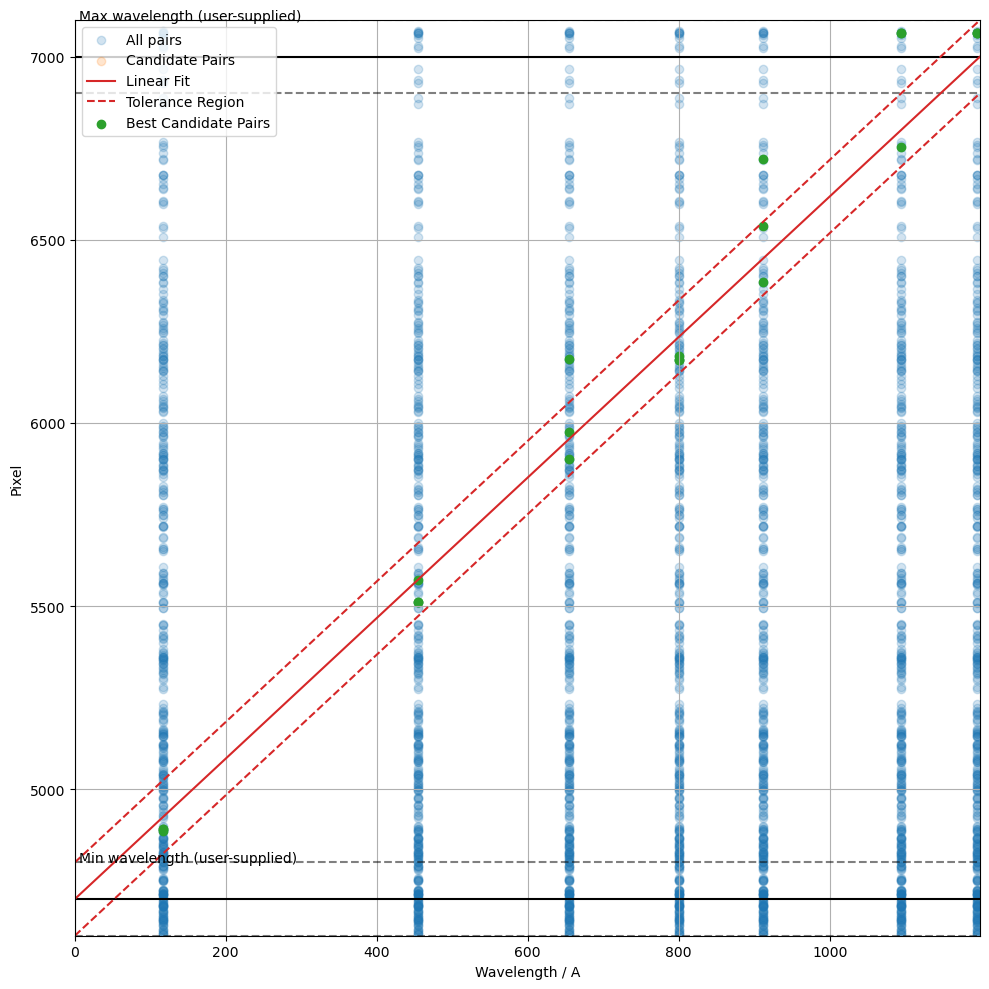

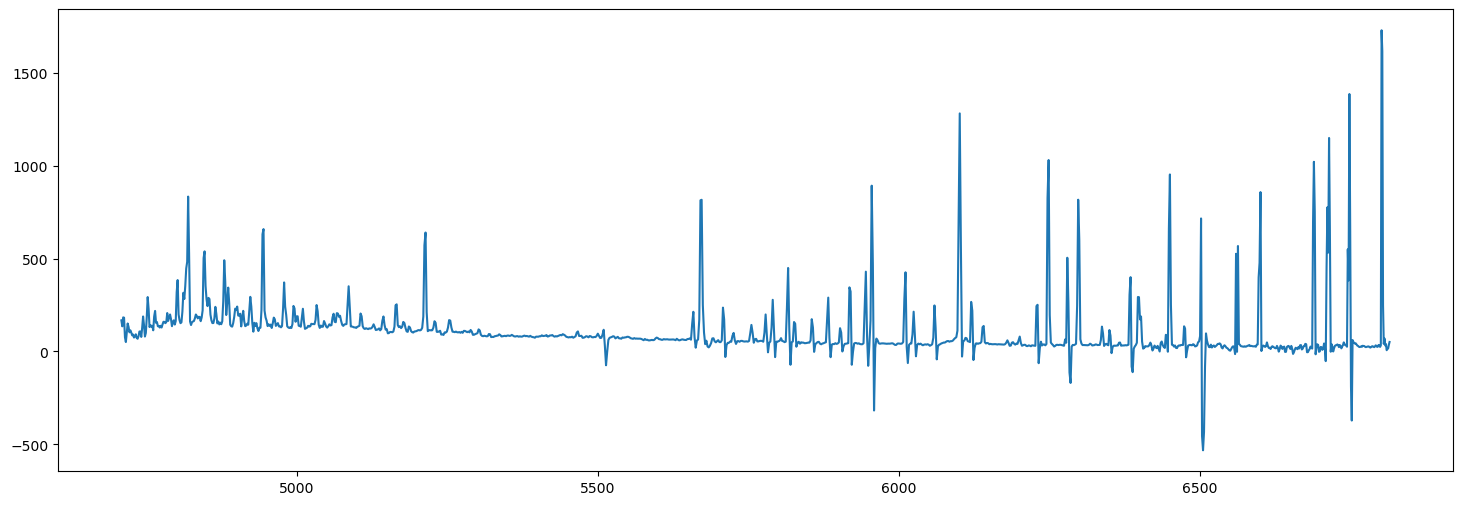

In [32]:
wave = wavelength_solver(arc1d, debug=True, line_brightness=0.01, dist=100)

### Flux Calibration

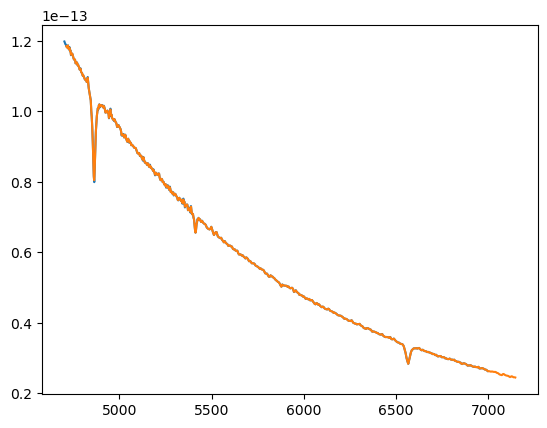

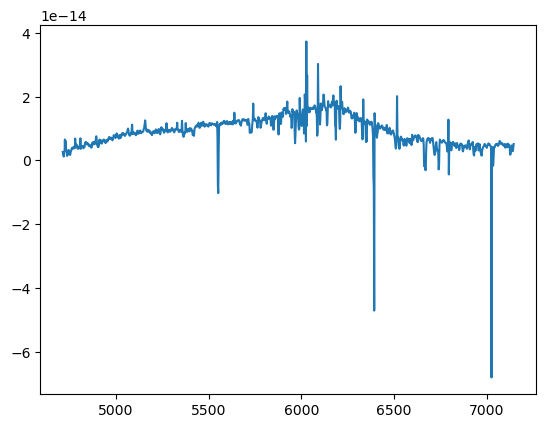

In [20]:
min_wave = 4700
max_wave = 7000

fl = calibrate_flux(stand1d, standard_name, min_wave, max_wave, debug=True)

# Development Code/Notes

### Tracing Method 1: Using `argmax`

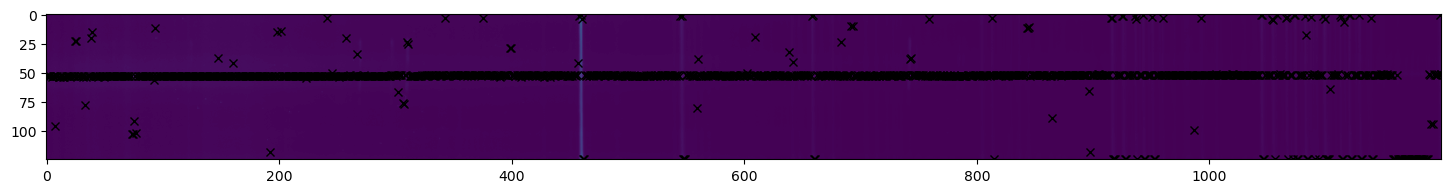

In [8]:
yvals = np.argmax(science_red, axis=0)
xvals = np.arange(science_red.shape[1])

fig, ax = plt.subplots(figsize=(18,6))
ax.imshow(science_red)
ax.plot(xvals, yvals, 'kx')

52


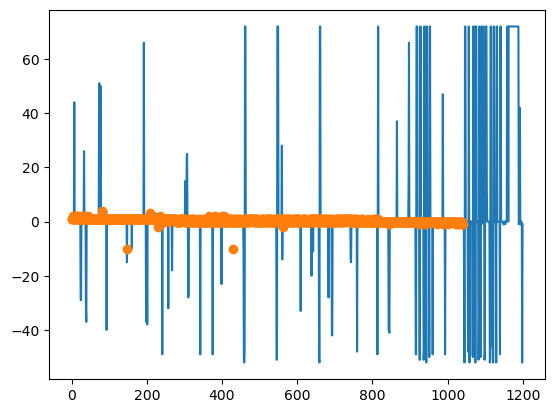

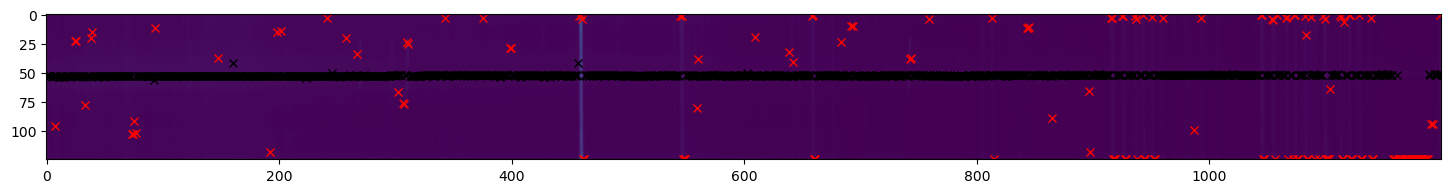

In [9]:
# get the most common yval
# and then only take values relatively close to it

ycomm = np.bincount(yvals).argmax()
print(ycomm)
ydim = spectra2d.shape[0]
factor = 10
# round the dimension to the nearest hundredth
# then divide by some factor to eliminate most outliers 
limit = np.round(ydim, decimals=1-len(str(ydim))) / factor

goodyvals = np.where(np.abs(yvals-ycomm) <= limit)[0]
badyvals = np.where(np.abs(yvals-ycomm) > limit)[0]

plt.figure()
plt.plot(yvals-ycomm)
plt.plot(yvals[goodyvals]-ycomm, 'o')

fig, ax = plt.subplots(figsize=(18,6))
ax.imshow(science_red)
ax.plot(xvals[goodyvals], yvals[goodyvals], 'kx')
ax.plot(xvals[badyvals], yvals[badyvals], 'rx')

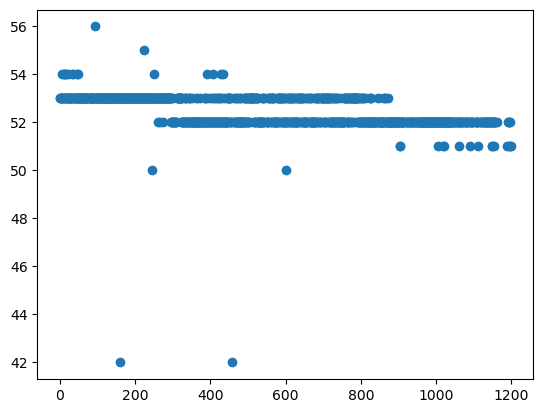

In [10]:
# we can now set these as the "official" good maximums

ymax = yvals[goodyvals]
xmax = xvals[goodyvals]

plt.plot(xmax, ymax, 'o')

### Tracing Method 2: Using Moments

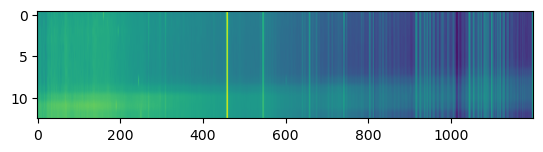

In [11]:
plt.imshow(science_red[42:55 :], norm=LogNorm())
plt.gca().set_aspect(20)

/home/nfranz/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


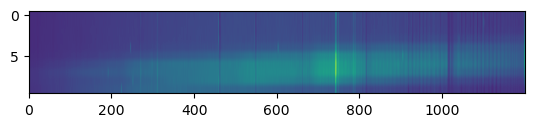

In [12]:
# background subtract 

# estimate the most common value
factor = 5
yhist = np.histogram(yvals, len(yvals)//factor)
ycomm_idx = yhist[0].argmax()
ycomm = int(yhist[1][ycomm_idx])

ydim = spectra2d.shape[0]

yaxis = np.repeat(np.arange(ycomm-factor, ycomm+factor)[:,None],
                  spectra2d.shape[1], axis=1)

# one way to define background
#background=np.median(spectra2d)

# arguably a better way to define background
background = deepcopy(spectra2d.data)
background[ycomm-factor:ycomm+factor, :] = 0 # set all of these to no background signal
background=np.median(spectra2d, axis=0)

yvals = np.average(yaxis, axis=0,
                  weights=spectra2d[ycomm-factor:ycomm+factor, :]-background)

plt.imshow(spectra2d[ycomm-factor:ycomm+factor, :]-background)
plt.gca().set_aspect(20)

51.39148255551888 2.6377438862439146


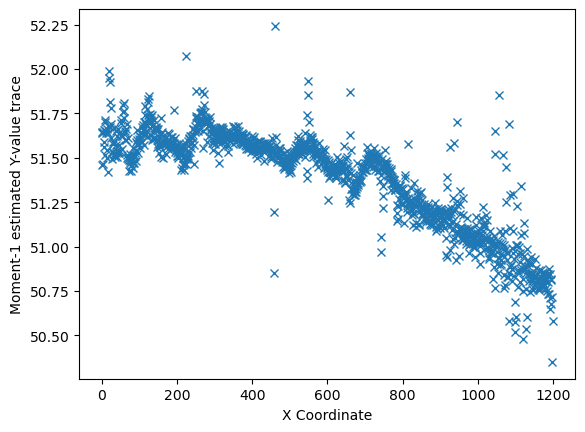

In [13]:
# another way to do this edge-finding is with a moment estimation


# remove outliers
# this is highly non-gaussian so take the median and remove values
nsigma = 5
med = np.mean(yvals)
q = np.std(yvals)
print(med, nsigma*q)
whereNotOutlier = np.where((yvals < (med+nsigma*q)) * (yvals > (med-nsigma*q)))[0] 

plt.figure()
#plt.imshow(science_red[38:58, :], extent=[0,spectra2d.shape[1],38,58], norm=LogNorm(), cmap='Greys')
plt.plot(xvals[whereNotOutlier], yvals[whereNotOutlier], 'x')
plt.xlabel("X Coordinate")
plt.ylabel("Moment-1 estimated Y-value trace");

xmax = xvals[whereNotOutlier]
ymax = yvals[whereNotOutlier]

### Fitting a line to the trace

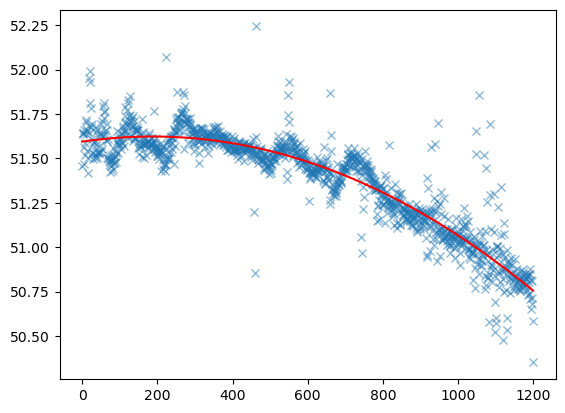

In [14]:
polymodel = Polynomial1D(degree=3)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, xmax, ymax)

plt.plot(xmax, ymax, 'x', alpha=0.5)
plt.plot(xmax, fitted_polymodel(xmax), color='r');

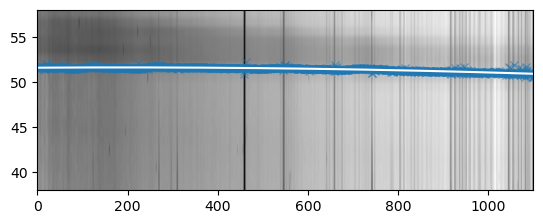

In [15]:
plt.figure()
plt.imshow(science_red[38:58, :], extent=[0,spectra2d.shape[1],38,58], norm=LogNorm(), cmap='Greys', origin='lower')
plt.gca().set_aspect(20)
plt.plot(xmax, ymax, 'x', alpha=0.5)
plt.plot(xvals, fitted_polymodel(xvals), 'w-', alpha=1)
plt.axis((0,1100,38,58));

### Now take a trace profile region

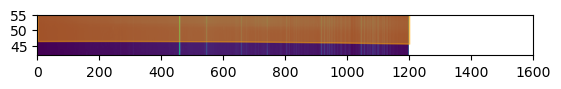

In [16]:
n = 5
center = fitted_polymodel(xvals)


plt.imshow(spectra2d[42:55,:], extent=[0,spectra2d.shape[1],42,55], origin='lower')
plt.gca().set_aspect(10)
plt.fill_between(xvals, fitted_polymodel(xvals)-n,
                fitted_polymodel(xvals)+n,
                color='orange', alpha=0.5)
plt.axis((0,1600,42,55));



### Auto Extract a Trace Profile (Algorithm I'm creating off the top of my head)

Here's the general idea
1. Create a region that follows the shape of the best fit trace with initial width, `width_init`, around the best fit trace
2. Iterate over widths at dwidth to see which includes the maximum amount of light fraction up to a certain amount

How can we automatically determine `width_init`???

In [17]:
spec = spectra2d.data

max_frac = 0.1 # THIS MIGHT NEED TO GET TUNED BY HAND!!!

width_init = 1
center_init = fitted_polymodel(xvals)
light_frac_init = compute_light_frac(spec, center_init, width_init)

dwidth = 1
up = True
light_frac = light_frac_init
width = width_init

while light_frac < max_frac:

    new_light_frac = compute_light_frac(spec, center, width)
    if new_light_frac > light_frac:
        light_frac = new_light_frac
    
    print(light_frac)
    width += dwidth

0.020596963848377715
0.04152287449752026
0.062441092280326745
0.08256815464531533
0.10155082433085272


In [18]:
width, center

(6,
 array([51.59412292, 51.59443013, 51.5947357 , ..., 50.75927942,
        50.75754922, 50.75581724]))

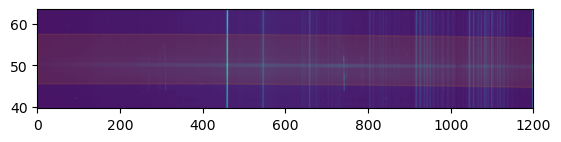

In [19]:
center = fitted_polymodel(xvals)

plt.imshow(spectra2d, extent=[0,spectra2d.shape[1],center[0]-2*width,center[0]+2*width], origin='lower')
plt.gca().set_aspect(10)
plt.fill_between(xvals, center-width,
                center+width,
                color='orange', alpha=0.1)

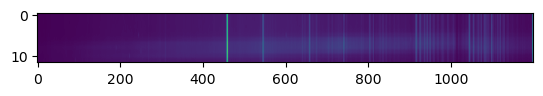

In [20]:
cutout = np.array([spectra2d.data[int(val)-width:int(val)+width, ii] for ii, val in enumerate(center)]).T
plt.imshow(cutout)
plt.gca().set_aspect(10)

In [21]:
cutout-background.data

array([[139.75,  23.5 ,  28.5 , ..., 112.25, 152.  , 408.25],
       [135.75,  30.75,  25.25, ..., 131.  , 182.25, 427.  ],
       [138.  ,  25.  ,  26.  , ...,  90.75, 190.25, 488.25],
       ...,
       [327.25,  71.5 ,  64.5 , ..., 240.5 , 276.25, 935.75],
       [323.75,  61.  ,  61.25, ..., 127.5 , 149.5 , 624.  ],
       [312.5 ,  64.25,  58.5 , ...,  47.  ,  68.25, 292.75]])

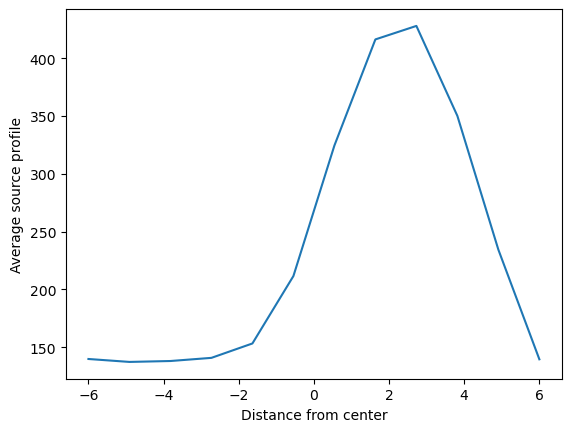

In [22]:
cutout_trace = (cutout-background.data).mean(axis=1)
cutout_trace_x = np.linspace(-width, width, len(cutout_trace))
plt.plot(cutout_trace_x, cutout_trace)
plt.xlabel("Distance from center")
plt.ylabel("Average source profile");

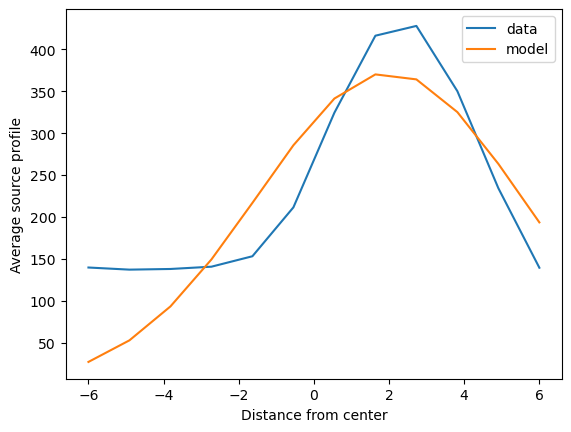

In [23]:
# now we model this with a gaussian

lmfitter = LevMarLSQFitter()
std = width/3 # just a guess?
guess = Gaussian1D(amplitude=cutout_trace.max(), mean=0, stddev=std)
fitted_trace_profile = lmfitter(model=guess, x=cutout_trace_x, y=cutout_trace)
cutout_trace_model = fitted_trace_profile(cutout_trace_x)

plt.plot(cutout_trace_x, cutout_trace, label='data')
plt.plot(cutout_trace_x, cutout_trace_model, label='model')
plt.legend(loc='best')
plt.xlabel("Distance from center")
plt.ylabel("Average source profile");

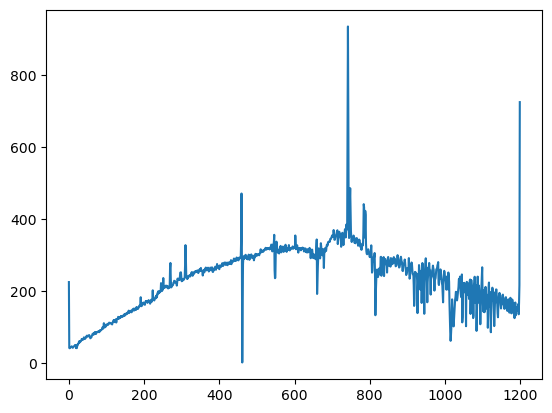

In [24]:
# to extract the spectrum
spectrum1d = (cutout-background).mean(axis=0)
plt.plot(spectrum1d)

### Wavelength Calibration Time

99 68
1200
(14, 1200)


[Wed, 20 Dec 2023 14:41:14] INFO [calibrator.py:930] num_pix is set to 1200.
[Wed, 20 Dec 2023 14:41:14] INFO [calibrator.py:942] pixel_list is set to None.
[Wed, 20 Dec 2023 14:41:14] INFO [calibrator.py:971] Plotting with matplotlib.
[Wed, 20 Dec 2023 14:41:14] WARNING [calibrator.py:1299] Using add_atlas is now deprecated. Please use the new Atlas class.


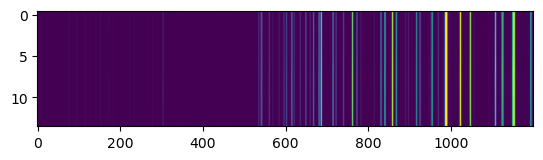

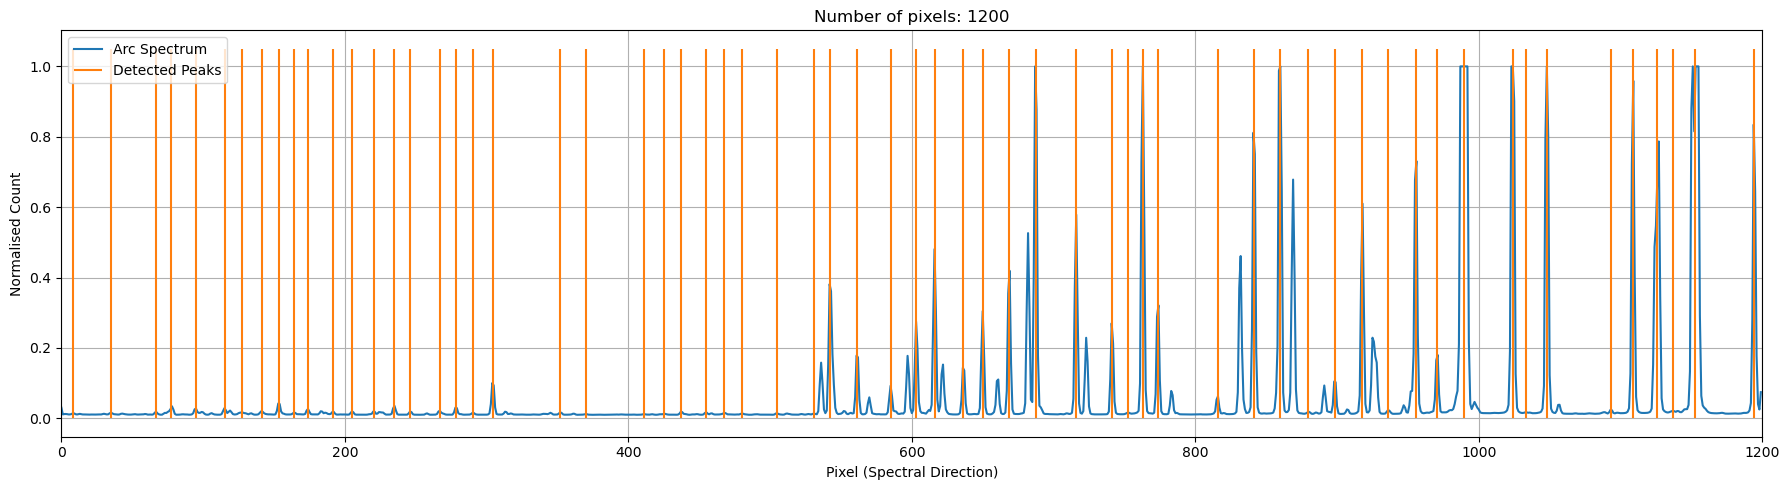

In [37]:
# extract a 1d crossection from the arc data
arc1d = extract_1d(arc2d.data, background_subtract=False, debug=False)

# Now following from https://rascal.readthedocs.io/en/latest/tutorial/keck-deimos.html
peaks, _ = find_peaks(arc1d, prominence=100, distance=10)
peaks_refined = refine_peaks(arc1d, peaks, window_width=3)

c = Calibrator(peaks_refined, arc1d)

c.set_calibrator_properties(num_pix=len(arc1d),
                            plotting_library='matplotlib',
                            log_level='info')

c.set_hough_properties(num_slopes=10000,
                       xbins=200,
                       ybins=200,
                       min_wavelength=4700.,
                       max_wavelength=7000.,
                       range_tolerance=100.,
                       linearity_tolerance=50)

c.set_ransac_properties(sample_size=5,
                        top_n_candidate=5,
                        linear=True,
                        filter_close=True,
                        ransac_tolerance=5,
                        candidate_weighted=True,
                        hough_weight=1.0)

c.add_atlas(['He', 'Ne', 'Ar'])

c.do_hough_transform()

c.plot_arc();

  0%|          | 0/500 [00:00<?, ?it/s]

[Wed, 20 Dec 2023 14:41:27] INFO [calibrator.py:750] Found: 7
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:805] Peak at: 4683.691880391446 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:809] - matched to 4683.691880391446 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:805] Peak at: 5182.240190081627 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:809] - matched to 5182.240190081627 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:805] Peak at: 5304.67666624496 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:809] - matched to 5304.67666624496 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:805] Peak at: 5366.134671918383 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:809] - matched to 5366.134671918383 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:805] Peak at: 5719.442576790948 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:809] - matched to 5719.442576790948 A
[Wed, 20 Dec 2023 14:41:27] INFO [plotting.py:805] Peak at: 5966.0878949910375 A
[Wed, 20 Dec 2023 14:41:27] INFO [plott

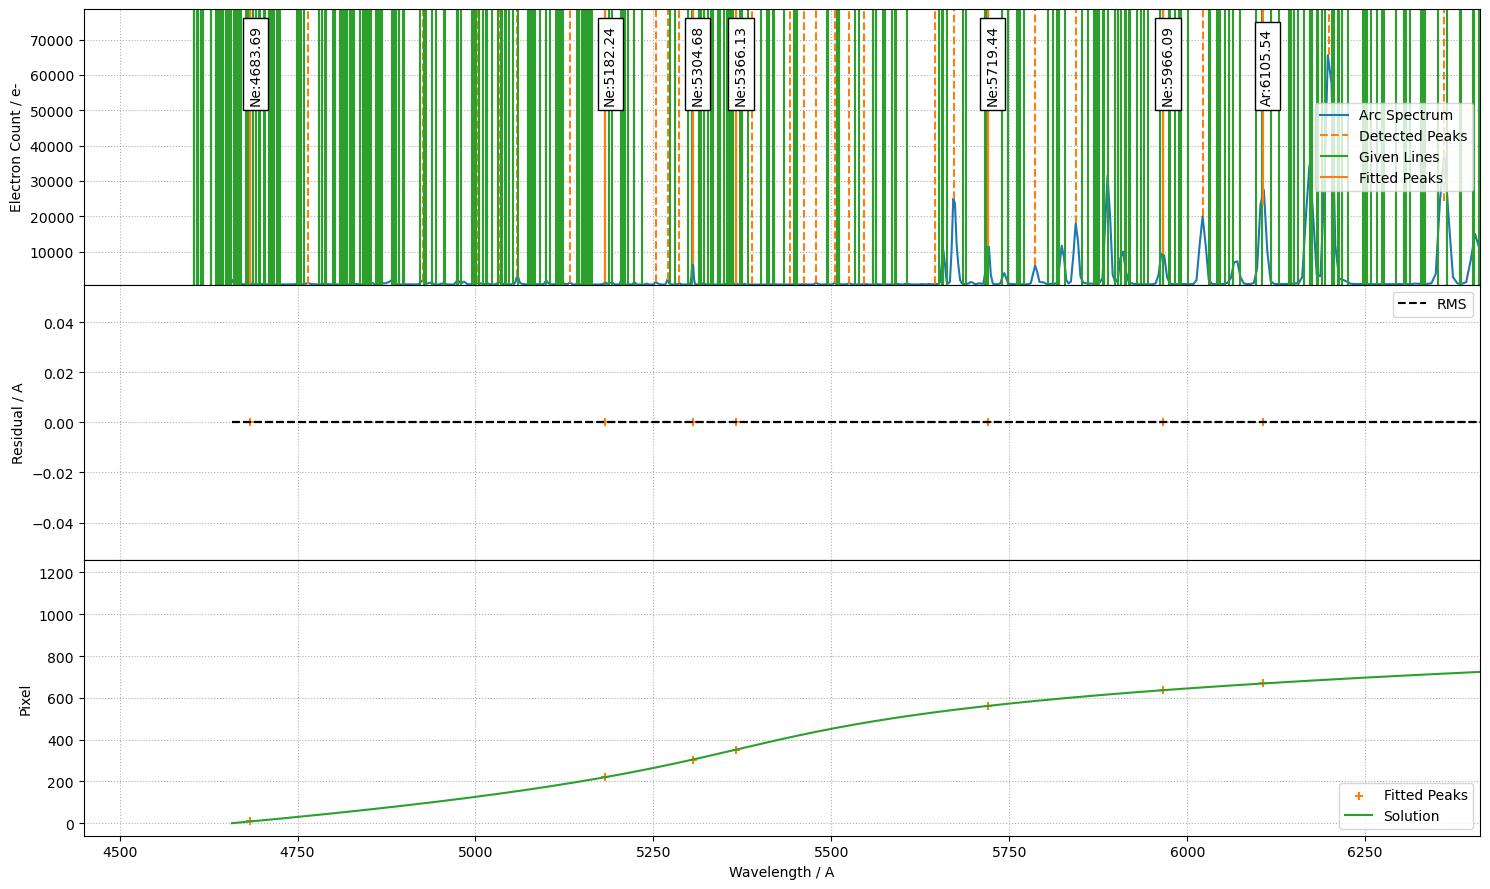

In [38]:
# now perform the fit
fit_coeff, matched_peaks, matched_atlas, rms, residual, peak_util, atlas_util = c.fit(max_tries=500)
c.plot_fit(fit_coeff,
           plot_atlas=True,
           log_spectrum=False,
           tolerance=5);

In [39]:
print("RMS: {}".format(rms))
print("Stdev error: {} A".format(np.abs(residual).std()))
print("Peaks utilisation rate: {}%".format(peak_util*100))

RMS: 0.44398903838208503
Stdev error: 0.24951397852055482 A
Peaks utilisation rate: 11.11111111111111%


In [40]:
#c.plot_search_space();

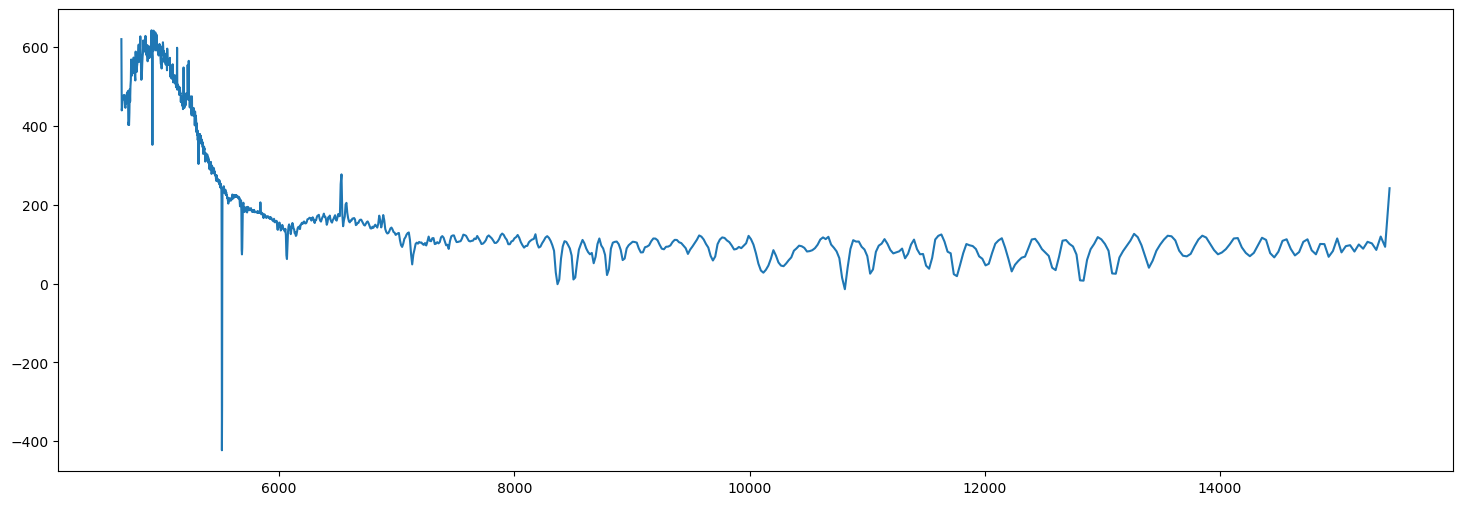

In [41]:
wave = c.polyval(c.pixel_list, fit_coeff)

plt.figure(figsize=(18,6))
plt.plot(wave, spec1d)

### Finally we can do the flux calibration

[54 54 54 ... 53 53 53]
180 55


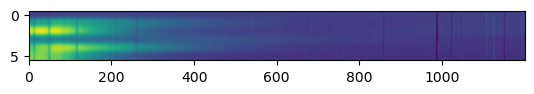

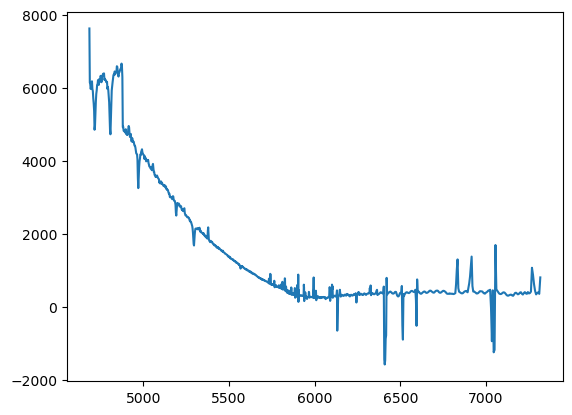

In [27]:
# extract the 1d spectrum from the standard star
stan1d = extract_1d(stan_red.data)
fig, ax = plt.subplots()
ax.plot(wave, stan1d)

In [138]:
def get_standard(standard_dir, standard_name):
    '''
    Find the standard star file corresponding to standaed_name
    '''
   
    filename_table = ascii.read(os.path.join(standard_dir, 'calspec_names.csv'))
    
    filenames = filename_table['current_calspec']
    targnames = np.array([name.split('_')[0] for name in filenames])
    
    forglob = os.path.join(standard_dir, '*.fits')
    curr_standards = [os.path.basename(f) for f in glob.glob(forglob)]
    
    # find the filename of the standard
    whereFile = np.where(standard_name.lower() == targnames)[0]
    if len(whereFile) == 0:
        raise ValueError('We do not have access to this standard star! Please contact the developers!')
    
    filename = filenames[whereFile[0]]
    
    if filename not in curr_standards:
        # then we need to download it!
        cmd = f'wget -P {standard_dir} https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/{filename}'
        run(cmd, shell=True)

    return filename

def calibrate_flux(standard_name, min_wave, max_wave, debug=False):
    '''
    Calibrate the flux using the standard star
    '''

    standard_dir = os.path.join(os.path.dirname(os.getcwd()), 'py', 'sonatapy', 'standards')
    
    filename = get_standard(standard_dir, standard_name)
    
    stand = fits.open(os.path.join(standard_dir, filename))

    stand_flux = stand['SCI'].data['FLUX']
    stand_wave = stand['SCI'].data['WAVELENGTH']
    
    whereFilt = np.where((stand_wave > min_wave) * (stand_wave < max_wave))[0]

    if debug:
        plt.plot(stand_wave[whereFilt], stand_flux[whereFilt])
    
    # interpolate stand_flux is the same length as stand1d
    bestfit = interp1d(stand_wave, stand_flux)
    stand_interp = bestfit(wave)

    if debug:
        plt.plot(wave, stand_interp)

    # let's introduce units to make sure this is okay
    stand_obs = stan1d*u.count
    stand = stand_interp*u.erg/u.cm**2/u.s
    flux_obs = spec1d.data*u.count
    
    flux = flux_obs * stand / stand_obs

    if debug:
        plt.figure()
        plt.plot(wave, flux)

    return flux

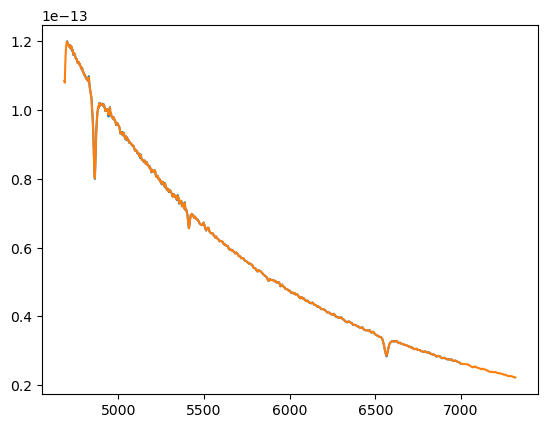

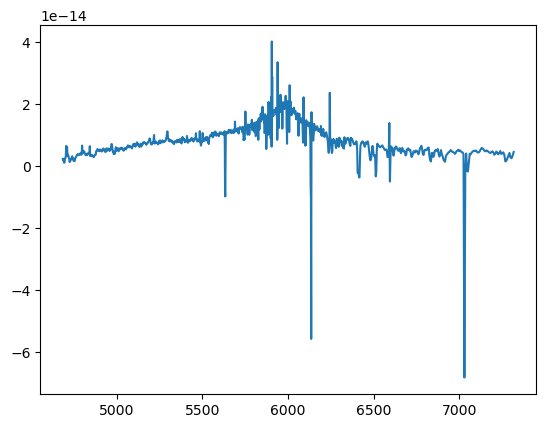

In [140]:
min_wave = 4700
max_wave = 7000

fl = calibrate_flux(standard_name, min_wave, max_wave, debug=True)

In [96]:
# grab the data from calspec

from astropy.io import ascii
from subprocess import run

standard_name = 'feige110'
min_wave = 4700
max_wave = 7000

filename_table = ascii.read(os.path.join(os.path.dirname(os.getcwd()), 'py', 'sonatapy', 'standards', 'calspec_names.csv'))

filenames = filename_table['current_calspec']
targnames = np.array([name.split('_')[0] for name in filenames])

standard_dir = os.path.join(os.path.dirname(os.getcwd()), 'py', 'sonatapy', 'standards')
forglob = os.path.join(standard_dir, '*.fits')
curr_standards = [os.path.basename(f) for f in glob.glob(forglob)]

# find the filename of the standard
whereFile = np.where(standard_name.lower() == targnames)[0]
if len(whereFile) == 0:
    raise ValueError('We do not have access to this standard star! Please contact the developers!')

filename = filenames[whereFile[0]]

if filename not in curr_standards:
    # then we need to download it!
    cmd = f'wget -P {standard_dir} https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/{filename}'
    run(cmd, shell=True)
    

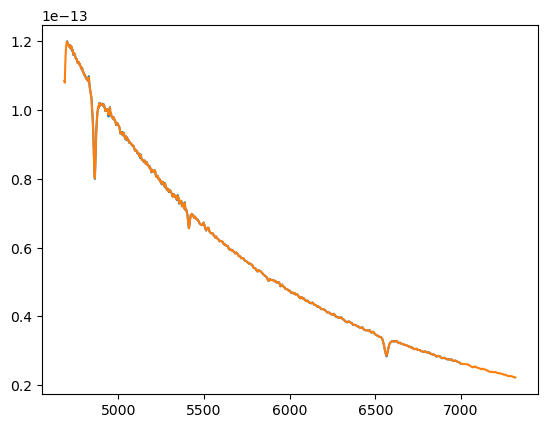

In [131]:
# read in the standard file

from scipy.signal import resample
from scipy.interpolate import interp1d

stand = fits.open(os.path.join(standard_dir, filename))

stand_flux = stand['SCI'].data['FLUX']
stand_wave = stand['SCI'].data['WAVELENGTH']

whereFilt = np.where((stand_wave > min_wave) * (stand_wave < max_wave))[0]

plt.plot(stand_wave[whereFilt], stand_flux[whereFilt])

# interpolate stand_flux is the same length as stand1d
bestfit = interp1d(stand_wave, stand_flux)
stand_interp = bestfit(wave)

plt.plot(wave, stand_interp)


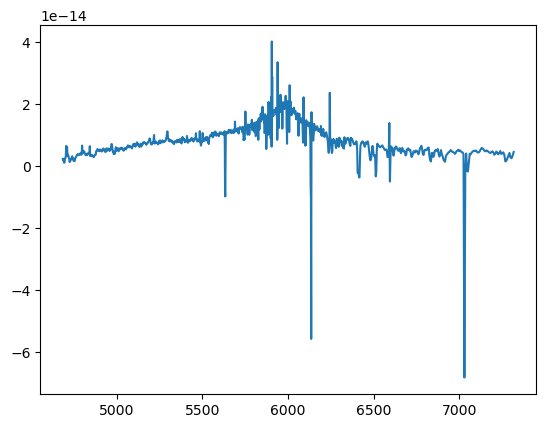

In [134]:
# let's introduce units to make sure this is okay
stand_obs = stan1d*u.count
stand = stand_interp*u.erg/u.cm**2/u.s
flux_obs = spec1d.data*u.count

flux = flux_obs * stand / stand_obs

plt.plot(wave, flux)

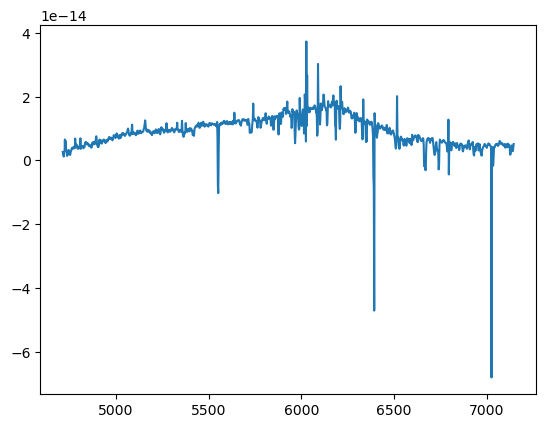

In [25]:
fitspath = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'bok', '2023Dec14', 'reduced', 'at2019qiz-reduced.fits')

with fits.open(fitspath) as f:
    wave, flux = f[0].data
    plt.plot(wave, flux)